# Virtually Straining a Biological Tissue with a Conditional GAN

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch09_GAN/ec09_B_virtual_staining/virtual_staining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [1]:
# !pip install deeplay  # Uncomment if using Colab/Kaggle.

The virtual_staining.ipynb notebook provides you with a complete code example to virtually stain a biological tissue with a conditional GAN

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 9-B from the book  

**Deep Learning Crash Course**  
Giovanni Volpe, Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo  
No Starch Press, San Francisco (CA), 2026  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Downloading the Human Motor Neurons Dataset

You’ll use a dataset that was originally published in the article: E. M. Christiansen et al., Cell 173:792-803, 2018. Specifically, you’ll use the human motor neurons dataset that is designated as “Condition A” in the article. This dataset comprises 22 pairs of brightfield and corresponding fluorescent images, with each pair including spatially registered images showcasing two fluorescent channels: Hoechst stain, revealing nuclei with a blue stain, and anti-TuJ1 stain, highlighting neurons in green. Notably, the brightfield images encompass a z-stack of 13 images across different focal planes, offering a comprehensive view of the cellular structures in question.

Download the virtual staining dataset.

In [2]:
import os

if not os.path.exists("vs_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/vs_dataset")

## Creating a Dataset

Implement a class containing the dataset ...

In [3]:
import glob
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm

class VirtualStainingDataset(torch.utils.data.Dataset):
    """Dataset containing the brightfield and fluorescence images."""

    _cache = {}  # Class variable to cache loaded images.

    def __init__(self, dir, transforms=None, preload=False):
        """Initialize dataset."""
        self.dir, self.transforms, self.preload = dir, transforms, preload
        self.images = []

        pattern = ("lab-Rubin,condition-scott_1_0,acquisition_date,"
                   "year-2016,month-2,day-6,well-r0*c0*,depth_computation,"
                   "value-MAXPROJECT,is_mask-false,kind,value-ORIGINAL.png")
        self.image_list = glob.glob(os.path.join(self.dir, pattern))

        if self.preload:
            if dir in VirtualStainingDataset._cache:
                self.images = VirtualStainingDataset._cache[dir]
            else:
                for image_path in tqdm(self.image_list,
                                       total=len(self.image_list),
                                       desc="Preloading images ..."):
                    self.images.append(self.load_image(image_path))
                VirtualStainingDataset._cache[dir] = self.images

    def load_image(self, image_path):
        """Load input-target image couple."""
        input_image = []
        for i in range(13):
            image_path_i = (
                image_path.replace("MAXPROJECT", "BRIGHTFIELD")
                .replace("depth_computation", f"z_depth-{i},channel")
            )
            input_image.append(np.array(Image.open(image_path_i).convert("L")))
        input_image = np.stack(input_image, axis=-1)

        target_image = np.array(Image.open(image_path))

        return input_image, target_image

    def __len__(self):
        """Return number of images."""
        return len(self.image_list)

    def __getitem__(self, i):
        """Get input-target image couple."""
        if self.preload:
            input_image, target_image = self.images[i]
        else:
            input_image, target_image = self.load_image(self.image_list[i])

        if self.transforms:
            seed = np.random.randint(1_000_000_000)
            torch.manual_seed(seed)
            input_image = self.transforms[0](input_image)
            torch.manual_seed(seed)
            target_image = self.transforms[1](target_image)

        return input_image, target_image

... define the image transformations and normalizations ...

In [4]:
from torchvision import transforms

trans_bright = transforms.Compose([
    transforms.ToTensor(), transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(p=.5), transforms.RandomVerticalFlip(p=.5),
    transforms.Normalize(mean=[0.5] * 13, std=[0.5] * 13),
])
trans_fluorescent = transforms.Compose([
    transforms.ToTensor(), transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(p=.5), transforms.RandomVerticalFlip(p=.5),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])

... create the training and testing datasets ...

In [5]:
train_set = VirtualStainingDataset(
    dir=os.path.join("vs_dataset", "train"),
    transforms=[trans_bright, trans_fluorescent], preload=True,
)
test_set = VirtualStainingDataset(
    dir=os.path.join("vs_dataset", "test"),
    transforms=[trans_bright, trans_fluorescent], preload=True,
)

Preloading images ...: 100%|██████████| 3/3 [00:12<00:00,  4.04s/it]


... and visualize brightfield and corresponding fluorescence images.

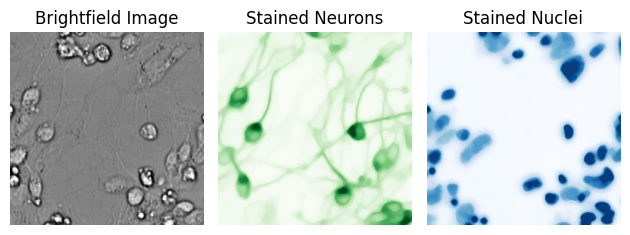

In [6]:
import matplotlib.pyplot as plt

input_image, target_image = train_set[np.random.randint(0, len(train_set))]

def denormalize(image):
    """Denormalize image for visualization."""
    return (image + 1) / 2

plt.subplot(1, 3, 1)
plt.imshow(input_image.mean(axis=0), cmap="gray")
plt.title("Brightfield Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(denormalize(target_image[1, :, :].numpy()), cmap="Greens")
plt.title("Stained Neurons")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(denormalize(target_image[2, :, :].numpy()), cmap="Blues")
plt.title("Stained Nuclei")
plt.axis("off")

plt.tight_layout()
plt.show()

## Instantiating the Generator and Discriminator

Determine the device to be used in the computations ...

In [7]:
def get_device():
    """Select device where to perform the computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

print(device)

mps


... define the generator ...

In [8]:
import deeplay as dl
from torch.nn import InstanceNorm2d, LeakyReLU, Tanh

gen = dl.UNet2d(
    in_channels=13, channels=[32, 64, 128, 256, 512], out_channels=3,
)
gen["encoder", ..., "activation"].configure(LeakyReLU, negative_slope=0.2)
gen["decoder", ..., "activation#:-1"].configure(LeakyReLU, negative_slope=0.2)
gen["decoder", ..., "activation#-1"].configure(Tanh)
gen["decoder", "blocks", :-1].all.normalized(InstanceNorm2d)
gen[..., "blocks"].configure(order=["layer", "normalization", "activation"])
gen.build().to(device);

... print out the generator's architecture ...

In [9]:
print(gen)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(13, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): Conv2dBlock(
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): Conv2dBlock(
        (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (4): Conv2dBlock(
        (layer): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (postprocess): Identity()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (b

... define the discriminator ...

In [10]:
from torch.nn import Sigmoid

disc = dl.ConvolutionalNeuralNetwork(
    in_channels=16, hidden_channels=[8, 16, 32, 64], out_channels=1,
)
disc["blocks", ..., "layer"].configure(kernel_size=4, stride=2, padding=1)
disc["blocks", ..., "activation#-1"].configure(LeakyReLU, negative_slope=0.2)
disc["blocks", 1:-1].all.normalized(InstanceNorm2d)
disc["blocks", ..., "activation#-1"].configure(Sigmoid)
disc["blocks"].configure(order=["layer", "normalization", "activation"])
disc.build().to(device);

... and print out the discriminator's architecture.

In [11]:
print(disc)

ConvolutionalNeuralNetwork(
  (blocks): LayerList(
    (0): Conv2dBlock(
      (layer): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
    )
    (1): Conv2dBlock(
      (layer): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): ReLU()
    )
    (2): Conv2dBlock(
      (layer): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): ReLU()
    )
    (3): Conv2dBlock(
      (layer): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): ReLU()
    )
    (4): Conv2dBlock(
      (layer): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2

## Compiling the Conditional GAN

Define the losses ...

In [12]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

loss_disc = torch.nn.MSELoss()
loss_recon = torch.nn.L1Loss()
loss_percep = LearnedPerceptualImagePatchSimilarity(net_type="vgg").to(device)

... define the optimizers ...

In [13]:
optim_gen = torch.optim.Adam(gen.parameters(), lr=.0002, betas=(.5, .999))
optim_disc = torch.optim.Adam(disc.parameters(), lr=.00005, betas=(.5, .999))

... and define the data loaders.

In [14]:
train_loader = dl.DataLoader(train_set, batch_size=2, shuffle=True)
test_loader = dl.DataLoader(test_set, batch_size=2, shuffle=False)

## Training the Conditional GAN

Define a function to train the discriminator ...

In [15]:
def train_disc(inputs, targets, optim_disc, loss_disc):
    """Train the discriminator."""
    optim_disc.zero_grad()

    # Compute real loss.
    disc_outputs_real = disc(torch.cat([inputs, targets], dim=1))
    labels_real = torch.ones_like(disc_outputs_real)
    disc_loss_real = loss_disc(disc_outputs_real, labels_real)

    # Compute fake loss.
    gen_outputs = gen(inputs)
    disc_outputs_fake = disc(torch.cat([inputs, gen_outputs], dim=1))
    labels_fake = torch.zeros_like(disc_outputs_fake)
    disc_loss_fake = loss_disc(disc_outputs_fake, labels_fake)

    disc_loss = (disc_loss_real + disc_loss_fake) / 2
    disc_loss.backward()
    optim_disc.step()

    return disc_loss

... define a function to train the generator ...

In [16]:
def train_gen(inputs, targets, optim_gen, loss_disc, loss_recon, loss_percep,
              recon_coef=100, percep_coef=10):
    """Train the generator."""
    optim_gen.zero_grad()

    gen_outputs = gen(inputs)
    disc_outputs = disc(torch.cat([inputs, gen_outputs], dim=1))

    labels = torch.ones_like(disc_outputs)
    adv_loss = loss_disc(disc_outputs, labels)
    recon_loss = loss_recon(gen_outputs, targets)
    percep_loss = loss_percep(gen_outputs, targets)

    gen_loss = adv_loss + recon_coef * recon_loss + percep_coef * percep_loss
    gen_loss.backward()
    optim_gen.step()

    return gen_loss, adv_loss, recon_loss, percep_loss

... and a function to evaluate the model on the test dataset ...

In [17]:
def evaluate_model(input, target):
    """Evaluate model on test data."""
    gen.eval()
    with torch.no_grad():
        prediction = gen(input.to(device))
    gen.train()

    fig, ax = plt.subplots(2, 3, figsize=(10, 7))
    
    ax[0, 0].imshow(
        denormalize(input[0].permute(1, 2, 0).cpu().numpy().mean(axis=-1)),
        cmap="gray",
    )
    ax[0, 0].set_title("Input Image")
    ax[0, 0].axis("off")
    
    ax[0, 1].imshow(
        denormalize(prediction[0].permute(1, 2, 0).cpu().numpy())[:, :, 1],
        cmap="Greens",
    )
    ax[0, 1].set_title("Prediction - Neurons")
    ax[0, 1].axis("off")

    ax[1, 1].imshow(
        denormalize(target[0].permute(1, 2, 0).cpu().numpy())[:, :, 1],
        cmap="Greens",
    )
    ax[1, 1].set_title("Ground Truth - Neurons")
    ax[1, 1].axis("off")

    ax[0, 2].imshow(
        denormalize(prediction[0].permute(1, 2, 0).cpu().numpy())[:, :, 2],
        cmap="Blues",
    )
    ax[0, 2].set_title("Prediction - Nuclei")
    ax[0, 2].axis("off")

    ax[1, 2].imshow(
        denormalize(target[0].permute(1, 2, 0).cpu().numpy())[:, :, 2],
        cmap="Blues",
    )
    ax[1, 2].set_title("Ground Truth - Nuclei")
    ax[1, 2].axis("off")

    ax[1, 0].axis("off")  # Leave the [1, 0] subplot empty

    plt.tight_layout()
    plt.show()
    plt.close(fig)

... and implement the training cycle.


Epoch 1/500
----------
Batch 1/11 : Total Generator Loss: 69.3286, Discriminator Loss: 0.2538
Batch 6/11 : Total Generator Loss: 44.0141, Discriminator Loss: 0.2526
Batch 11/11 : Total Generator Loss: 30.0944, Discriminator Loss: 0.2592


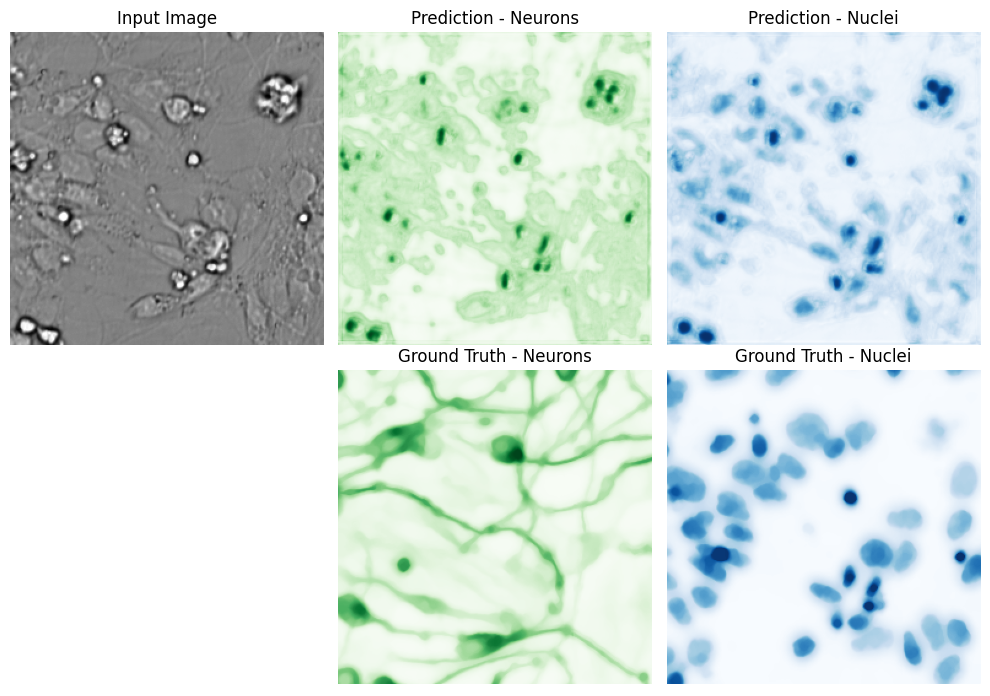

----------
Epoch 1/500 : Discriminator Loss: 0.2579, Total Generator Loss: 45.6382, Reconstrucntion Loss: 0.3938, Perceptual Loss: 0.5998
Time taken: 0:00:57.775137

Epoch 2/500
----------
Batch 1/11 : Total Generator Loss: 29.4043, Discriminator Loss: 0.2564
Batch 6/11 : Total Generator Loss: 22.8666, Discriminator Loss: 0.2555
Batch 11/11 : Total Generator Loss: 19.8603, Discriminator Loss: 0.2594
----------
Epoch 2/500 : Discriminator Loss: 0.2579, Total Generator Loss: 23.9655, Reconstrucntion Loss: 0.1863, Perceptual Loss: 0.5081
Time taken: 0:00:56.900816

Epoch 3/500
----------
Batch 1/11 : Total Generator Loss: 20.9147, Discriminator Loss: 0.2562
Batch 6/11 : Total Generator Loss: 17.1121, Discriminator Loss: 0.2557
Batch 11/11 : Total Generator Loss: 15.8410, Discriminator Loss: 0.2575
----------
Epoch 3/500 : Discriminator Loss: 0.2564, Total Generator Loss: 18.0484, Reconstrucntion Loss: 0.1331, Perceptual Loss: 0.4482
Time taken: 0:00:57.458033

Epoch 4/500
----------
Batch

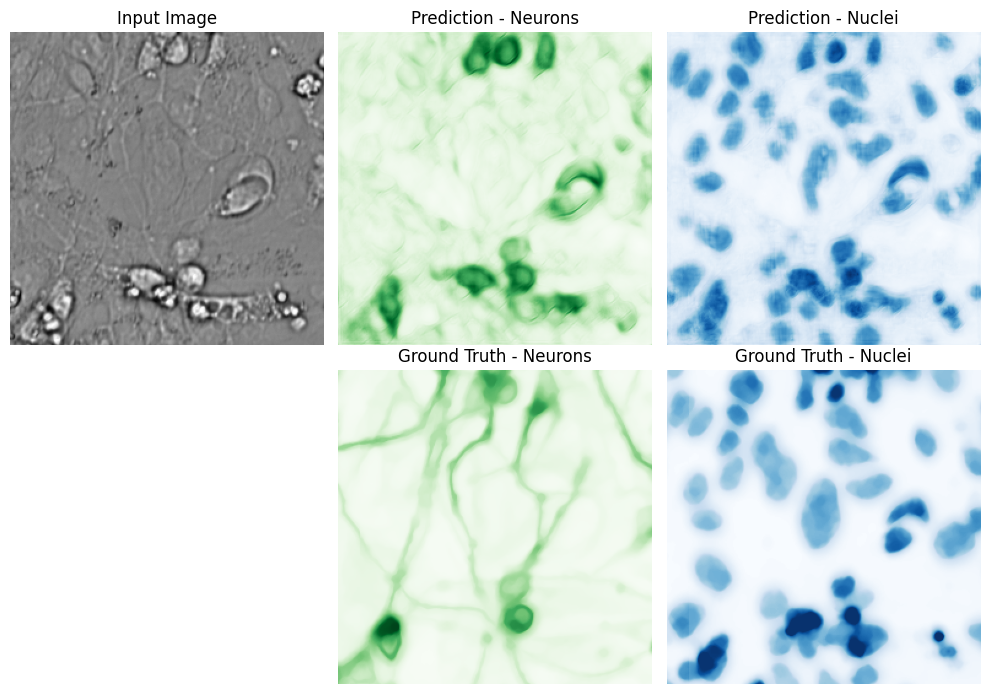

----------
Epoch 51/500 : Discriminator Loss: 0.2510, Total Generator Loss: 9.2391, Reconstrucntion Loss: 0.0598, Perceptual Loss: 0.3004
Time taken: 0:00:57.265894

Epoch 52/500
----------
Batch 1/11 : Total Generator Loss: 10.2890, Discriminator Loss: 0.2520
Batch 6/11 : Total Generator Loss: 8.8377, Discriminator Loss: 0.2490
Batch 11/11 : Total Generator Loss: 8.8695, Discriminator Loss: 0.2519
----------
Epoch 52/500 : Discriminator Loss: 0.2511, Total Generator Loss: 9.4387, Reconstrucntion Loss: 0.0612, Perceptual Loss: 0.3068
Time taken: 0:00:57.120195

Epoch 53/500
----------
Batch 1/11 : Total Generator Loss: 9.5839, Discriminator Loss: 0.2511
Batch 6/11 : Total Generator Loss: 7.1955, Discriminator Loss: 0.2512
Batch 11/11 : Total Generator Loss: 11.7824, Discriminator Loss: 0.2503
----------
Epoch 53/500 : Discriminator Loss: 0.2512, Total Generator Loss: 9.2506, Reconstrucntion Loss: 0.0600, Perceptual Loss: 0.3001
Time taken: 0:01:00.314804

Epoch 54/500
----------
Batch 

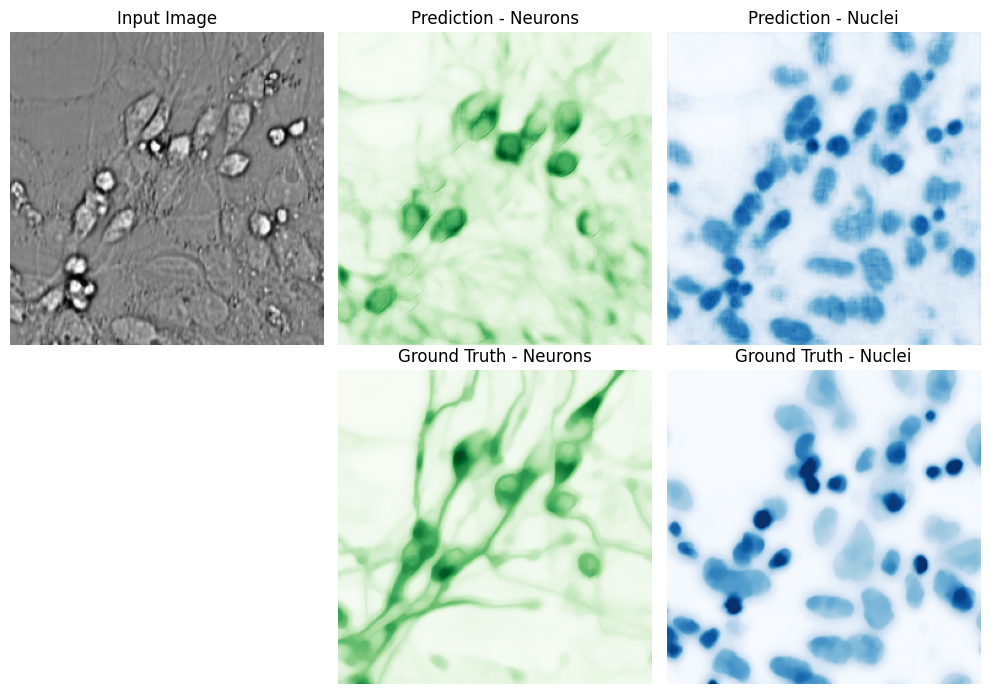

----------
Epoch 101/500 : Discriminator Loss: 0.2123, Total Generator Loss: 9.1103, Reconstrucntion Loss: 0.0585, Perceptual Loss: 0.2950
Time taken: 0:00:51.497621

Epoch 102/500
----------
Batch 1/11 : Total Generator Loss: 8.5394, Discriminator Loss: 0.2113
Batch 6/11 : Total Generator Loss: 9.8128, Discriminator Loss: 0.1969
Batch 11/11 : Total Generator Loss: 8.8895, Discriminator Loss: 0.2269
----------
Epoch 102/500 : Discriminator Loss: 0.2089, Total Generator Loss: 8.7872, Reconstrucntion Loss: 0.0570, Perceptual Loss: 0.2784
Time taken: 0:00:51.502926

Epoch 103/500
----------
Batch 1/11 : Total Generator Loss: 7.0106, Discriminator Loss: 0.2026
Batch 6/11 : Total Generator Loss: 9.1995, Discriminator Loss: 0.2061
Batch 11/11 : Total Generator Loss: 8.2610, Discriminator Loss: 0.2341
----------
Epoch 103/500 : Discriminator Loss: 0.2046, Total Generator Loss: 8.7224, Reconstrucntion Loss: 0.0556, Perceptual Loss: 0.2853
Time taken: 0:00:51.456984

Epoch 104/500
----------
Ba

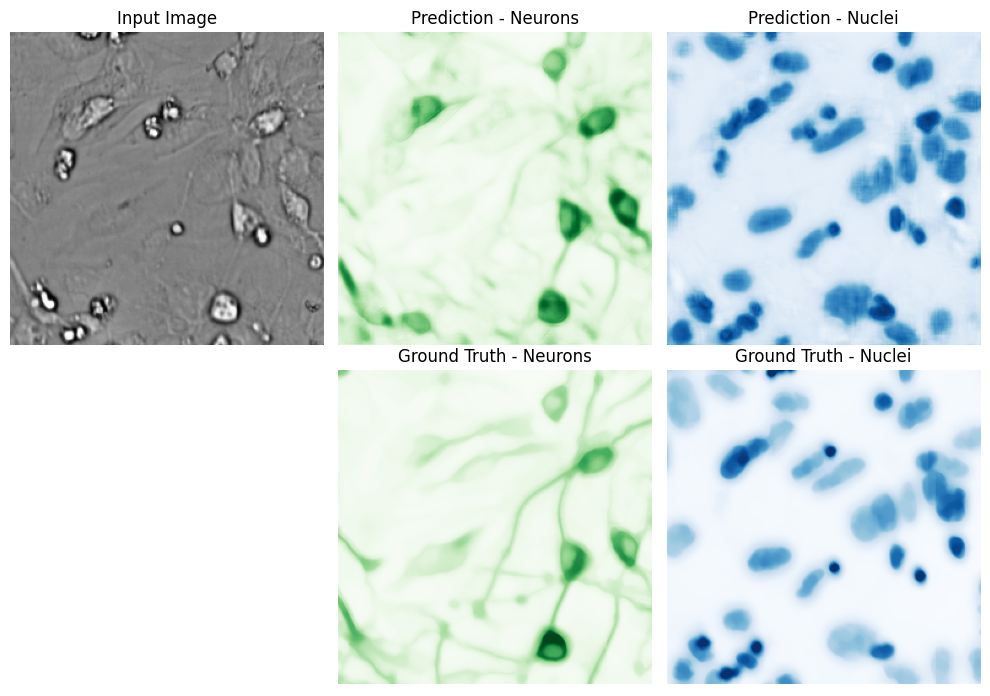

----------
Epoch 151/500 : Discriminator Loss: 0.2006, Total Generator Loss: 8.3699, Reconstrucntion Loss: 0.0535, Perceptual Loss: 0.2655
Time taken: 0:00:51.540979

Epoch 152/500
----------
Batch 1/11 : Total Generator Loss: 7.9701, Discriminator Loss: 0.2333
Batch 6/11 : Total Generator Loss: 9.3494, Discriminator Loss: 0.2246
Batch 11/11 : Total Generator Loss: 9.2271, Discriminator Loss: 0.2292
----------
Epoch 152/500 : Discriminator Loss: 0.1943, Total Generator Loss: 9.0003, Reconstrucntion Loss: 0.0585, Perceptual Loss: 0.2827
Time taken: 0:00:51.390215

Epoch 153/500
----------
Batch 1/11 : Total Generator Loss: 8.7364, Discriminator Loss: 0.1823
Batch 6/11 : Total Generator Loss: 10.5993, Discriminator Loss: 0.2352
Batch 11/11 : Total Generator Loss: 9.4414, Discriminator Loss: 0.1806
----------
Epoch 153/500 : Discriminator Loss: 0.1909, Total Generator Loss: 8.9361, Reconstrucntion Loss: 0.0577, Perceptual Loss: 0.2840
Time taken: 0:00:51.593626

Epoch 154/500
----------
B

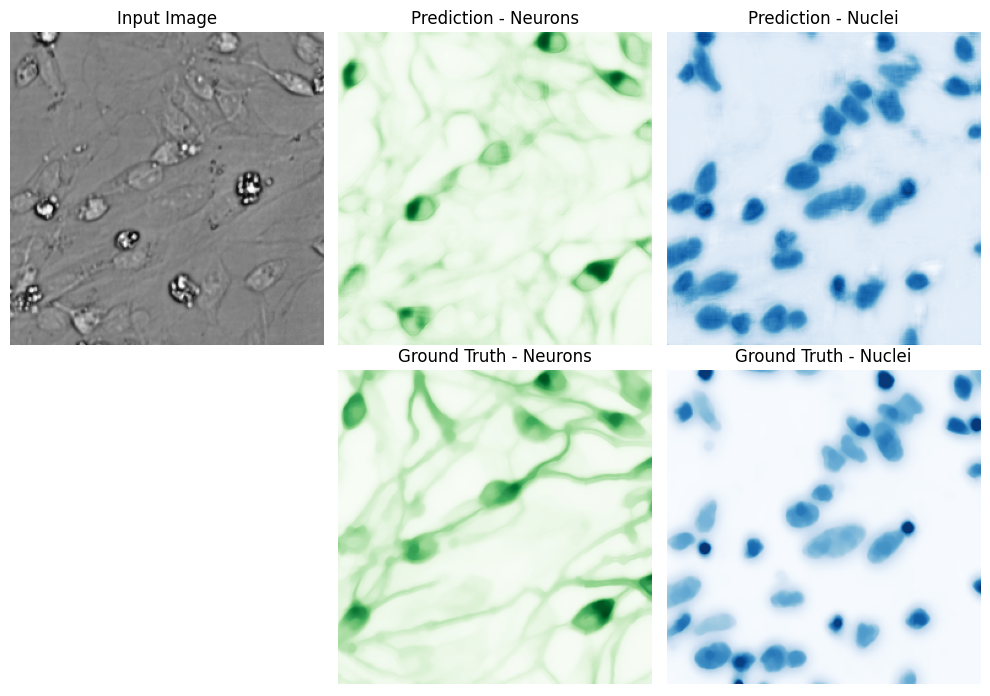

----------
Epoch 201/500 : Discriminator Loss: 0.2066, Total Generator Loss: 8.6670, Reconstrucntion Loss: 0.0564, Perceptual Loss: 0.2682
Time taken: 0:00:51.522942

Epoch 202/500
----------
Batch 1/11 : Total Generator Loss: 7.4659, Discriminator Loss: 0.2447
Batch 6/11 : Total Generator Loss: 9.5569, Discriminator Loss: 0.2213
Batch 11/11 : Total Generator Loss: 7.8968, Discriminator Loss: 0.2374
----------
Epoch 202/500 : Discriminator Loss: 0.2051, Total Generator Loss: 8.2777, Reconstrucntion Loss: 0.0530, Perceptual Loss: 0.2624
Time taken: 0:00:51.420456

Epoch 203/500
----------
Batch 1/11 : Total Generator Loss: 9.5861, Discriminator Loss: 0.1016
Batch 6/11 : Total Generator Loss: 7.5523, Discriminator Loss: 0.1973
Batch 11/11 : Total Generator Loss: 9.8431, Discriminator Loss: 0.1561
----------
Epoch 203/500 : Discriminator Loss: 0.1828, Total Generator Loss: 8.6417, Reconstrucntion Loss: 0.0561, Perceptual Loss: 0.2701
Time taken: 0:00:51.506437

Epoch 204/500
----------
Ba

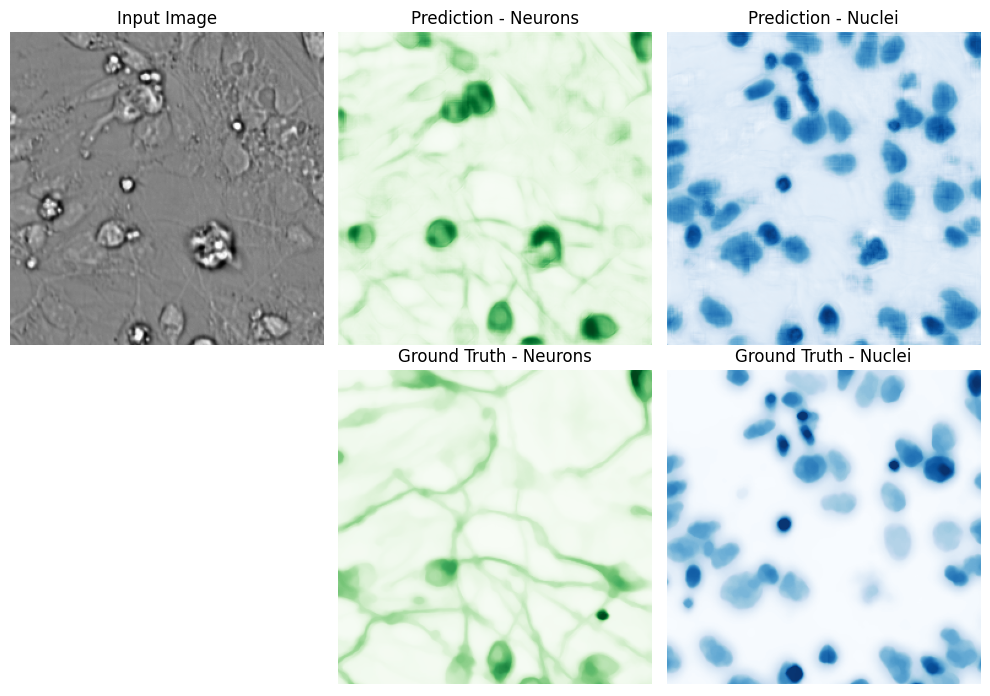

----------
Epoch 251/500 : Discriminator Loss: 0.1929, Total Generator Loss: 8.8571, Reconstrucntion Loss: 0.0578, Perceptual Loss: 0.2723
Time taken: 0:00:53.468604

Epoch 252/500
----------
Batch 1/11 : Total Generator Loss: 7.9870, Discriminator Loss: 0.2493
Batch 6/11 : Total Generator Loss: 7.1676, Discriminator Loss: 0.1383
Batch 11/11 : Total Generator Loss: 8.4487, Discriminator Loss: 0.1033
----------
Epoch 252/500 : Discriminator Loss: 0.1880, Total Generator Loss: 8.5610, Reconstrucntion Loss: 0.0542, Perceptual Loss: 0.2795
Time taken: 0:00:53.469949

Epoch 253/500
----------
Batch 1/11 : Total Generator Loss: 10.0894, Discriminator Loss: 0.2425
Batch 6/11 : Total Generator Loss: 8.6423, Discriminator Loss: 0.2009
Batch 11/11 : Total Generator Loss: 8.2131, Discriminator Loss: 0.1637
----------
Epoch 253/500 : Discriminator Loss: 0.1907, Total Generator Loss: 8.5349, Reconstrucntion Loss: 0.0553, Perceptual Loss: 0.2648
Time taken: 0:00:58.373213

Epoch 254/500
----------
B

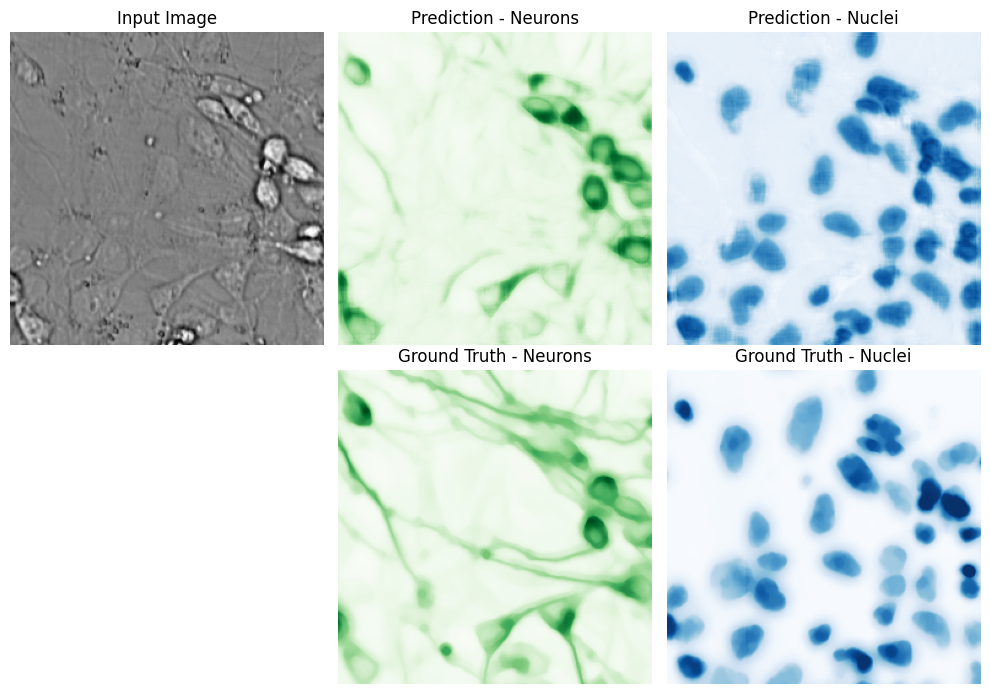

----------
Epoch 301/500 : Discriminator Loss: 0.1760, Total Generator Loss: 8.0578, Reconstrucntion Loss: 0.0518, Perceptual Loss: 0.2514
Time taken: 0:00:51.538326

Epoch 302/500
----------
Batch 1/11 : Total Generator Loss: 10.1768, Discriminator Loss: 0.1992
Batch 6/11 : Total Generator Loss: 8.1717, Discriminator Loss: 0.1937
Batch 11/11 : Total Generator Loss: 9.5721, Discriminator Loss: 0.1775
----------
Epoch 302/500 : Discriminator Loss: 0.1852, Total Generator Loss: 8.8496, Reconstrucntion Loss: 0.0572, Perceptual Loss: 0.2767
Time taken: 0:00:51.455977

Epoch 303/500
----------
Batch 1/11 : Total Generator Loss: 7.3916, Discriminator Loss: 0.2165
Batch 6/11 : Total Generator Loss: 8.2241, Discriminator Loss: 0.1532
Batch 11/11 : Total Generator Loss: 9.0793, Discriminator Loss: 0.2051
----------
Epoch 303/500 : Discriminator Loss: 0.1789, Total Generator Loss: 8.7321, Reconstrucntion Loss: 0.0565, Perceptual Loss: 0.2709
Time taken: 0:00:51.422790

Epoch 304/500
----------
B

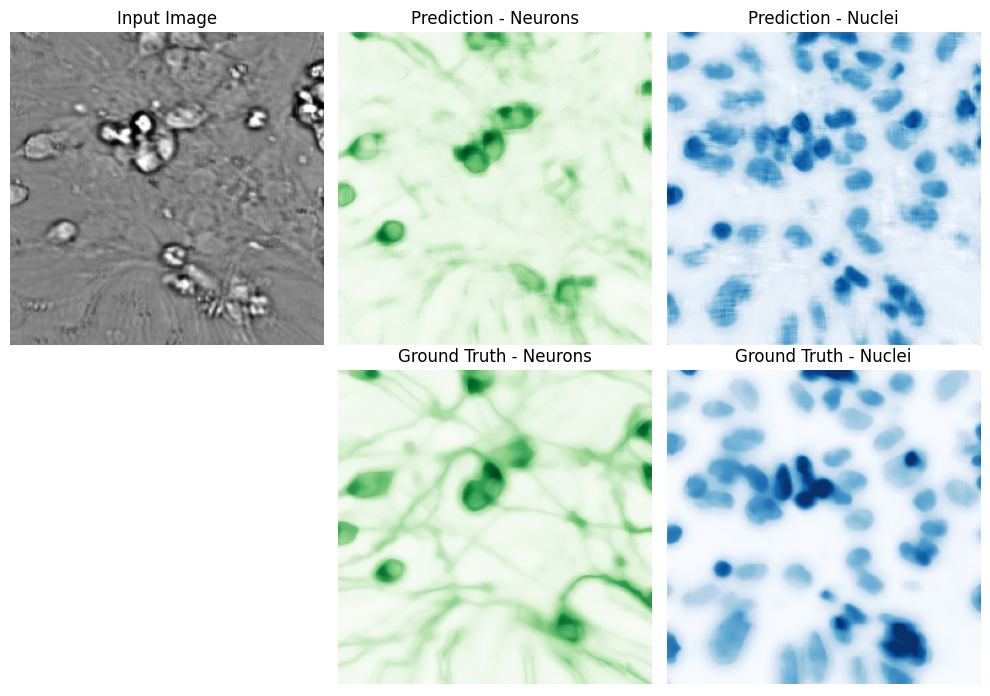

----------
Epoch 351/500 : Discriminator Loss: 0.1887, Total Generator Loss: 7.9850, Reconstrucntion Loss: 0.0511, Perceptual Loss: 0.2526
Time taken: 0:00:51.497107

Epoch 352/500
----------
Batch 1/11 : Total Generator Loss: 6.6704, Discriminator Loss: 0.1833
Batch 6/11 : Total Generator Loss: 7.6971, Discriminator Loss: 0.1449
Batch 11/11 : Total Generator Loss: 6.7007, Discriminator Loss: 0.3313
----------
Epoch 352/500 : Discriminator Loss: 0.1999, Total Generator Loss: 7.8976, Reconstrucntion Loss: 0.0506, Perceptual Loss: 0.2512
Time taken: 0:00:51.458762

Epoch 353/500
----------
Batch 1/11 : Total Generator Loss: 8.2985, Discriminator Loss: 0.1902
Batch 6/11 : Total Generator Loss: 9.1851, Discriminator Loss: 0.1405
Batch 11/11 : Total Generator Loss: 8.8085, Discriminator Loss: 0.2495
----------
Epoch 353/500 : Discriminator Loss: 0.1954, Total Generator Loss: 7.9999, Reconstrucntion Loss: 0.0510, Perceptual Loss: 0.2550
Time taken: 0:00:51.433684

Epoch 354/500
----------
Ba

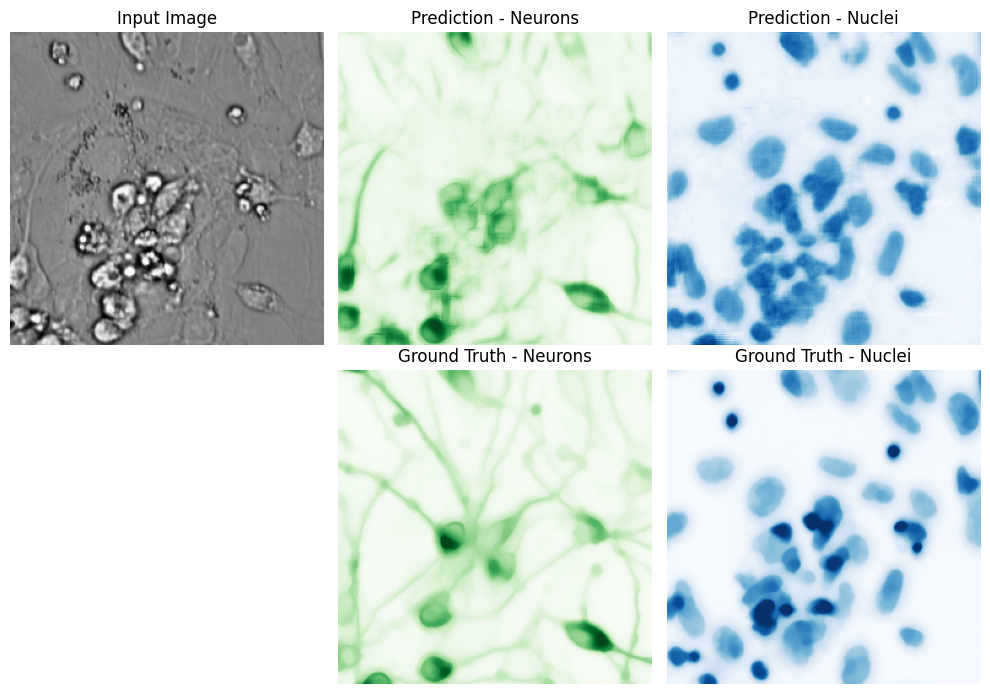

----------
Epoch 401/500 : Discriminator Loss: 0.1696, Total Generator Loss: 8.5111, Reconstrucntion Loss: 0.0555, Perceptual Loss: 0.2625
Time taken: 0:00:51.495632

Epoch 402/500
----------
Batch 1/11 : Total Generator Loss: 7.6105, Discriminator Loss: 0.2687
Batch 6/11 : Total Generator Loss: 7.6530, Discriminator Loss: 0.1903
Batch 11/11 : Total Generator Loss: 7.4015, Discriminator Loss: 0.2708
----------
Epoch 402/500 : Discriminator Loss: 0.1996, Total Generator Loss: 8.0878, Reconstrucntion Loss: 0.0511, Perceptual Loss: 0.2622
Time taken: 0:00:51.464567

Epoch 403/500
----------
Batch 1/11 : Total Generator Loss: 9.2767, Discriminator Loss: 0.2116
Batch 6/11 : Total Generator Loss: 7.4739, Discriminator Loss: 0.3223
Batch 11/11 : Total Generator Loss: 8.5589, Discriminator Loss: 0.1888
----------
Epoch 403/500 : Discriminator Loss: 0.2047, Total Generator Loss: 8.3613, Reconstrucntion Loss: 0.0533, Perceptual Loss: 0.2618
Time taken: 0:00:56.631073

Epoch 404/500
----------
Ba

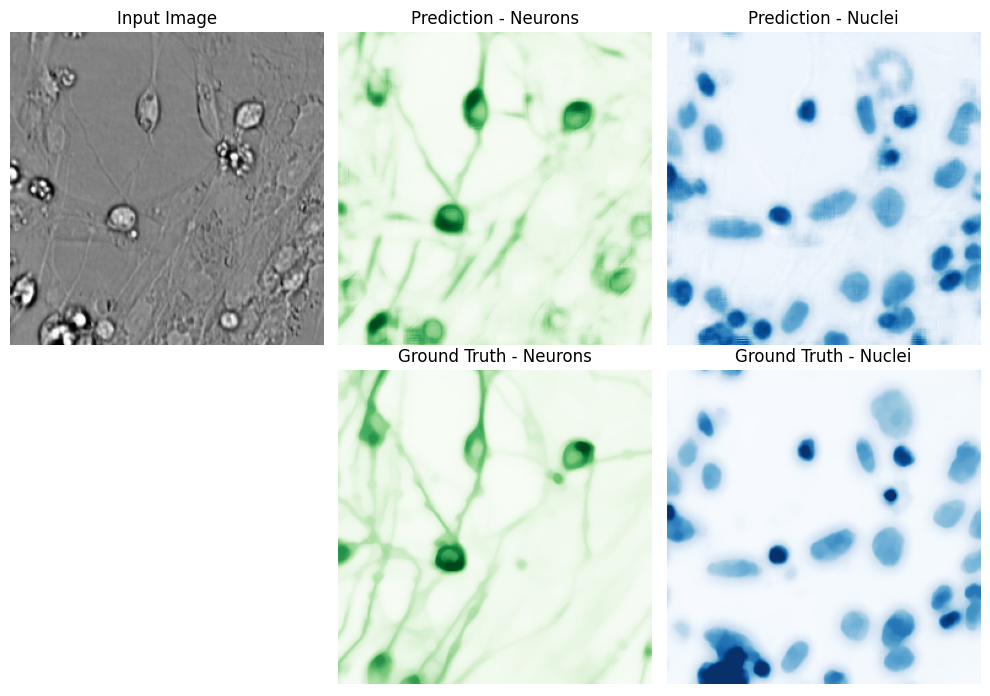

----------
Epoch 451/500 : Discriminator Loss: 0.1553, Total Generator Loss: 7.8830, Reconstrucntion Loss: 0.0495, Perceptual Loss: 0.2557
Time taken: 0:00:51.526901

Epoch 452/500
----------
Batch 1/11 : Total Generator Loss: 8.8696, Discriminator Loss: 0.1839
Batch 6/11 : Total Generator Loss: 9.3684, Discriminator Loss: 0.2597
Batch 11/11 : Total Generator Loss: 9.0860, Discriminator Loss: 0.1409
----------
Epoch 452/500 : Discriminator Loss: 0.1898, Total Generator Loss: 8.2952, Reconstrucntion Loss: 0.0529, Perceptual Loss: 0.2564
Time taken: 0:00:51.476003

Epoch 453/500
----------
Batch 1/11 : Total Generator Loss: 7.2619, Discriminator Loss: 0.2218
Batch 6/11 : Total Generator Loss: 9.5739, Discriminator Loss: 0.1197
Batch 11/11 : Total Generator Loss: 7.4639, Discriminator Loss: 0.2247
----------
Epoch 453/500 : Discriminator Loss: 0.1917, Total Generator Loss: 8.1045, Reconstrucntion Loss: 0.0511, Perceptual Loss: 0.2611
Time taken: 0:00:51.466581

Epoch 454/500
----------
Ba

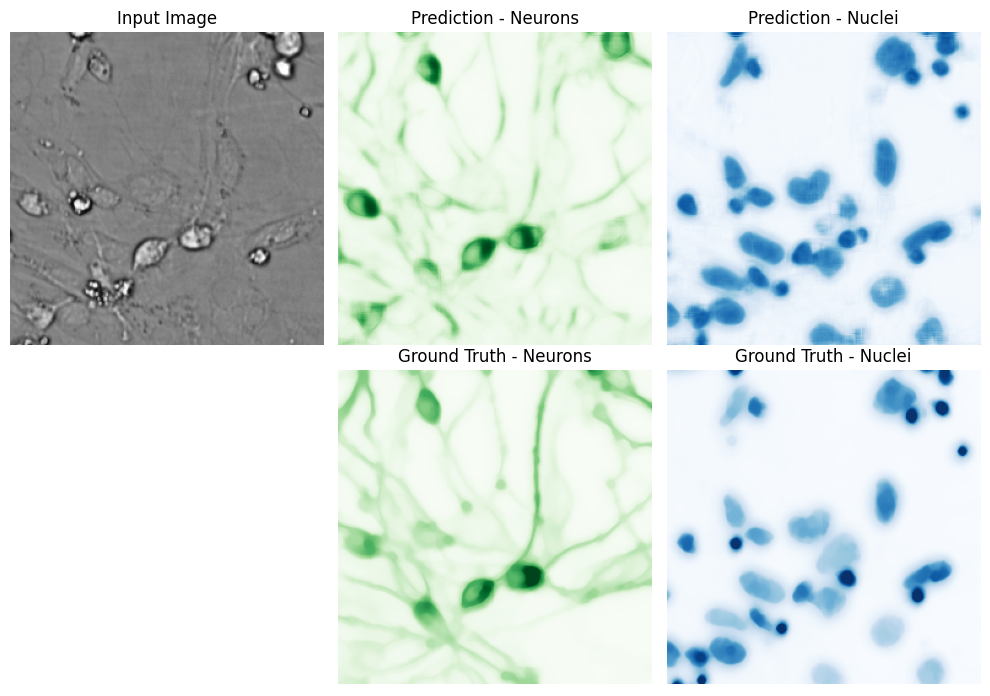

----------
Epoch 500/500 : Discriminator Loss: 0.2004, Total Generator Loss: 8.2210, Reconstrucntion Loss: 0.0530, Perceptual Loss: 0.2571
Time taken: 0:00:51.527178


In [ ]:
import time
from datetime import timedelta

epochs = 500

disc_losses, gen_losses, recon_losses, percep_losses = [], [], [], []
for epoch in range (epochs):
    start_time = time.time()
    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "-" * 10)

    disc_loss_epoch, gen_loss_epoch, recon_loss_epoch, percep_loss_epoch = \
        [], [], [], []
    for i, (inputs, targets) in enumerate(train_loader, 0):
        inputs, targets = inputs.to(device), targets.to(device)

        # 1. Train the discriminator.
        disc_loss = train_disc(inputs, targets, optim_disc, loss_disc)

        # 2. Train the generator.
        for _ in range(2):
            gen_loss, adv_loss, recon_loss, percep_loss = train_gen(
                inputs, targets, optim_gen, loss_disc, loss_recon, loss_percep,
            )

        if i % 5 == 0:
            print(f"Batch {i + 1}/{len(train_loader)} : "
                  f"Total Generator Loss: {gen_loss.item():.4f}, "
                  f"Discriminator Loss: {disc_loss.item():.4f}")

        disc_loss_epoch.append(disc_loss.item())
        gen_loss_epoch.append(gen_loss.item())
        recon_loss_epoch.append(recon_loss.item())
        percep_loss_epoch.append(percep_loss.item())
    
    end_time = time.time()

    disc_losses.append(np.mean(disc_loss_epoch))
    gen_losses.append(np.mean(gen_loss_epoch))
    recon_losses.append(np.mean(recon_loss_epoch))
    percep_losses.append(np.mean(percep_loss_epoch))

    print(f"-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : "
          f"Discriminator Loss: {disc_losses[-1]:.4f}, "
          f"Total Generator Loss: {gen_losses[-1]:.4f}, "
          f"Reconstrucntion Loss: {recon_losses[-1]:.4f}, "
          f"Perceptual Loss: {percep_losses[-1]:.4f}" + "\n"
          f"Time taken: {timedelta(seconds=end_time - start_time)}")

    if epoch % 50 == 0 or epoch + 1 == epochs:
        for i, (test_input, test_target) in enumerate(test_loader, 0):
            evaluate_model(test_input, test_target)
            break